# High Variance in LLM Reasoning: Root Cause Analysis

This notebook implements 4 creative analyses to understand why LLM reasoning exhibits unusually high variance:

1. **Latency-Based Reasoning Quality Clustering** - Do latency patterns predict correctness?
2. **Cache Reuse Impact on Consistency** - Does caching reduce variance but cap performance?
3. **Token Efficiency Frontiers** - Do different benchmarks have optimal token budgets?
4. **Multi-Agent Reasoning Diversity** - Does agent disagreement cause variance?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import re
from collections import defaultdict

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load strategy data from the latest parquet files
data_dir = Path("/Users/nearchospotamitis/CLAN/ReasonBench/data/strategies/repeats")
all_dataframes = []

for model_file in sorted(data_dir.glob("*/latest.parquet")):
    df = pd.read_parquet(model_file)
    df['model_name'] = model_file.parent.name
    all_dataframes.append(df)
    print(f"Loaded {model_file.parent.name}: {len(df)} configurations")

df_all = pd.concat(all_dataframes, ignore_index=True)
print(f"\nTotal configurations: {len(df_all)}")
print(f"Columns: {list(df_all.columns)}")

Loaded gpt-4.1-mini: 240 configurations
Loaded gpt-4.1-nano: 479 configurations
Loaded llama-4-scout-17b-16e-instruct: 48 configurations
Loaded qwen3-32b: 272 configurations

Total configurations: 1039
Columns: ['Method', 'Benchmark', 'Split', 'Dataset Path', "Using method's internal cache", 'Provider', 'Model', 'Temperature', 'Max Completion Tokens', 'Top-p', 'Stop', 'Logprobs', 'log', 'costs', 'costs_in', 'costs_out', 'tokens_in', 'tokens_out', 'scores', 'model_name']


## Analysis 1: Latency-Based Reasoning Quality Clustering

**Hypothesis:** Response latency patterns correlate with reasoning success. Fast responses might indicate cache hits (low variance, lower quality), while variable latencies might indicate genuine reasoning (higher variance, better exploration).

In [2]:
# Parse detailed log files to extract latency information
def parse_latencies_from_log(log_path):
    """
    Extract latency arrays from detailed log files.
    Format: "Latencies (in seconds): [0.217, 0.217, ...]"
    """
    try:
        with open(log_path, 'r') as f:
            content = f.read()
        
        # Find latency arrays
        match = re.search(r'Latencies \(in seconds\): \[([\d.,\s]+)\]', content)
        if match:
            latencies_str = match.group(1)
            latencies = [float(x.strip()) for x in latencies_str.split(',')]
            return latencies
    except:
        pass
    return None

def categorize_latency_pattern(latencies):
    """
    Classify latency patterns:
    - FAST_CONSISTENT: all latencies < 0.5s, low variance
    - FAST_WITH_SPIKES: mostly fast, but occasional spikes > 1s
    - VARIABLE_SLOW: high variance, generally > 1s
    - SLOW_WITH_BURSTS: mostly slow, but some fast responses
    """
    if len(latencies) < 2:
        return "UNKNOWN"
    
    mean_lat = np.mean(latencies)
    std_lat = np.std(latencies)
    cv = std_lat / mean_lat if mean_lat > 0 else 0  # coefficient of variation
    max_lat = np.max(latencies)
    fast_ratio = np.sum(np.array(latencies) < 0.5) / len(latencies)
    slow_ratio = np.sum(np.array(latencies) > 1.0) / len(latencies)
    
    if mean_lat < 0.5 and cv < 0.5:
        return "FAST_CONSISTENT"
    elif mean_lat < 1.0 and max_lat > 1.0:
        return "FAST_WITH_SPIKES"
    elif mean_lat > 1.0 and cv > 0.5:
        return "VARIABLE_SLOW"
    elif mean_lat > 1.0 and fast_ratio < 0.3:
        return "SLOW_WITH_BURSTS"
    else:
        return "MIXED"

# Analyze a sample of configurations
print("\n" + "="*100)
print("ANALYSIS 1: LATENCY-BASED REASONING QUALITY CLUSTERING")
print("="*100)

# For demonstration, analyze gpt-4.1-nano configurations
sample_df = df_all[df_all['model_name'] == list(df_all['model_name'].unique())[0]].head(10)

latency_analysis = []
for idx, row in sample_df.iterrows():
    log_path = row['log']
    if pd.isna(log_path):
        continue
    
    latencies = parse_latencies_from_log(log_path)
    if latencies is None:
        continue
    
    pattern = categorize_latency_pattern(latencies)
    scores = row['scores']
    
    # Calculate score statistics for this pattern
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    latency_analysis.append({
        'method': row['Method'],
        'benchmark': row['Benchmark'],
        'pattern': pattern,
        'mean_latency': np.mean(latencies),
        'std_latency': np.std(latencies),
        'cv_latency': np.std(latencies) / np.mean(latencies) if np.mean(latencies) > 0 else 0,
        'mean_score': mean_score,
        'std_score': std_score,
        'score_cv': std_score / mean_score if mean_score > 0 else 0,
        'max_score': np.max(scores),
        'num_successes': np.sum(scores > 0)
    })

latency_df = pd.DataFrame(latency_analysis)
print("\nLatency Pattern Analysis (sample):")
print(latency_df.to_string(index=False))

# Key findings
if len(latency_df) > 0:
    print("\n" + "-"*100)
    print("KEY FINDINGS:")
    print("-"*100)
    
    # Correlation between latency variability and score variability
    if 'cv_latency' in latency_df.columns and 'score_cv' in latency_df.columns:
        corr = latency_df['cv_latency'].corr(latency_df['score_cv'])
        print(f"\nCorrelation (Latency CV vs Score CV): {corr:.3f}")
        if abs(corr) > 0.3:
            print("  → Latency patterns STRONGLY correlate with score variance")
        elif abs(corr) > 0.1:
            print("  → Latency patterns show WEAK correlation with score variance")
        else:
            print("  → Latency patterns do NOT predict score variance")
    
    # Pattern vs performance
    print("\nLatency Pattern vs Performance:")
    pattern_stats = latency_df.groupby('pattern')['mean_score'].agg(['mean', 'std', 'count'])
    print(pattern_stats)


ANALYSIS 1: LATENCY-BASED REASONING QUALITY CLUSTERING

Latency Pattern Analysis (sample):
method benchmark          pattern  mean_latency  std_latency  cv_latency  mean_score  std_score  score_cv  max_score  num_successes
 react    game24    VARIABLE_SLOW      1.923525     1.056835    0.549426        0.02   0.140000  7.000000        1.0              1
   cot    game24          UNKNOWN    139.516923     0.000000    0.000000        0.70   0.458258  0.654654        1.0             35
   cot    game24          UNKNOWN      0.029126     0.000000    0.000000        0.86   0.346987  0.403473        1.0             43
   foa    game24 SLOW_WITH_BURSTS     28.128727     4.343622    0.154419        0.58   0.493559  0.850963        1.0             29
   cot    game24          UNKNOWN      0.161013     0.000000    0.000000        0.86   0.346987  0.403473        1.0             43
   cot    game24          UNKNOWN      0.030547     0.000000    0.000000        0.88   0.324962  0.369274        1.0

## Analysis 2: Cache Reuse Impact on Reasoning Consistency

**Hypothesis:** Heavy cache reuse reduces variance but caps maximum performance. Caching trades consistency for reduced exploration.

In [3]:
def parse_cache_reuse_from_log(log_path):
    """
    Extract cache reuse information from logs.
    Format: "Reuse (number of uses): [4, 3, 9, 6, 3, ...]"
    """
    try:
        with open(log_path, 'r') as f:
            content = f.read()
        
        # Find reuse arrays
        match = re.search(r'Reuse \(number of uses\): \[([\d.,\s]+)\]', content)
        if match:
            reuse_str = match.group(1)
            reuse_counts = [int(x.strip()) for x in reuse_str.split(',')]
            return reuse_counts
    except:
        pass
    return None

print("\n" + "="*100)
print("ANALYSIS 2: CACHE REUSE IMPACT ON REASONING CONSISTENCY")
print("="*100)

cache_analysis = []
for idx, row in df_all.iterrows():
    log_path = row['log']
    if pd.isna(log_path):
        continue
    
    reuse_counts = parse_cache_reuse_from_log(log_path)
    if reuse_counts is None:
        continue
    
    scores = row['scores']
    
    # Calculate cache reuse metrics
    total_reuses = np.sum(reuse_counts)
    num_cached_calls = len([r for r in reuse_counts if r > 0])
    cache_reuse_ratio = total_reuses / (len(reuse_counts) + 1) if len(reuse_counts) > 0 else 0
    
    # Score statistics
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_score = std_score / mean_score if mean_score > 0 else 0
    
    cache_analysis.append({
        'method': row['Method'],
        'benchmark': row['Benchmark'],
        'using_cache': row['Using method\'s internal cache'],
        'cache_reuse_ratio': cache_reuse_ratio,
        'mean_score': mean_score,
        'score_variance': std_score**2,
        'score_cv': cv_score
    })

cache_df = pd.DataFrame(cache_analysis)

if len(cache_df) > 0:
    print("\nCache Impact Summary:")
    print("-" * 100)
    
    # Compare cached vs non-cached
    cached_group = cache_df[cache_df['using_cache'] == True]
    noncached_group = cache_df[cache_df['using_cache'] == False]
    
    print(f"\nWith Cache (n={len(cached_group)}):")
    if len(cached_group) > 0:
        print(f"  Mean Score: {cached_group['mean_score'].mean():.3f}")
        print(f"  Score Variance: {cached_group['score_variance'].mean():.4f}")
        print(f"  Cache Reuse Ratio: {cached_group['cache_reuse_ratio'].mean():.3f}")
    
    print(f"\nWithout Cache (n={len(noncached_group)}):")
    if len(noncached_group) > 0:
        print(f"  Mean Score: {noncached_group['mean_score'].mean():.3f}")
        print(f"  Score Variance: {noncached_group['score_variance'].mean():.4f}")
        print(f"  Cache Reuse Ratio: {noncached_group['cache_reuse_ratio'].mean():.3f}")
    
    # Correlation analysis
    corr_reuse_score = cache_df['cache_reuse_ratio'].corr(cache_df['mean_score'])
    corr_reuse_var = cache_df['cache_reuse_ratio'].corr(cache_df['score_variance'])
    
    print(f"\nCorrelations:")
    print(f"  Cache Reuse vs Mean Score: {corr_reuse_score:.3f}")
    print(f"  Cache Reuse vs Score Variance: {corr_reuse_var:.3f}")
    
    if corr_reuse_var < -0.2:
        print("  → FINDING: Heavy caching REDUCES variance (negative correlation)")
    if corr_reuse_score > 0:
        print("  → FINDING: Caching correlates with HIGHER performance")
    elif corr_reuse_score < -0.2:
        print("  → FINDING: Caching correlates with LOWER performance (performance ceiling)")


ANALYSIS 2: CACHE REUSE IMPACT ON REASONING CONSISTENCY

Cache Impact Summary:
----------------------------------------------------------------------------------------------------

With Cache (n=611):
  Mean Score: 0.383
  Score Variance: 0.1342
  Cache Reuse Ratio: 3.003

Without Cache (n=428):
  Mean Score: 0.395
  Score Variance: 0.1512
  Cache Reuse Ratio: 1.840

Correlations:
  Cache Reuse vs Mean Score: 0.049
  Cache Reuse vs Score Variance: -0.066
  → FINDING: Caching correlates with HIGHER performance


## Analysis 3: Token Efficiency Frontiers by Problem Type

**Hypothesis:** Different benchmarks have different optimal token budgets. Some problems need more reasoning (more tokens help), while others suffer from over-explanation (more tokens hurt).


ANALYSIS 3: TOKEN EFFICIENCY FRONTIERS BY PROBLEM TYPE


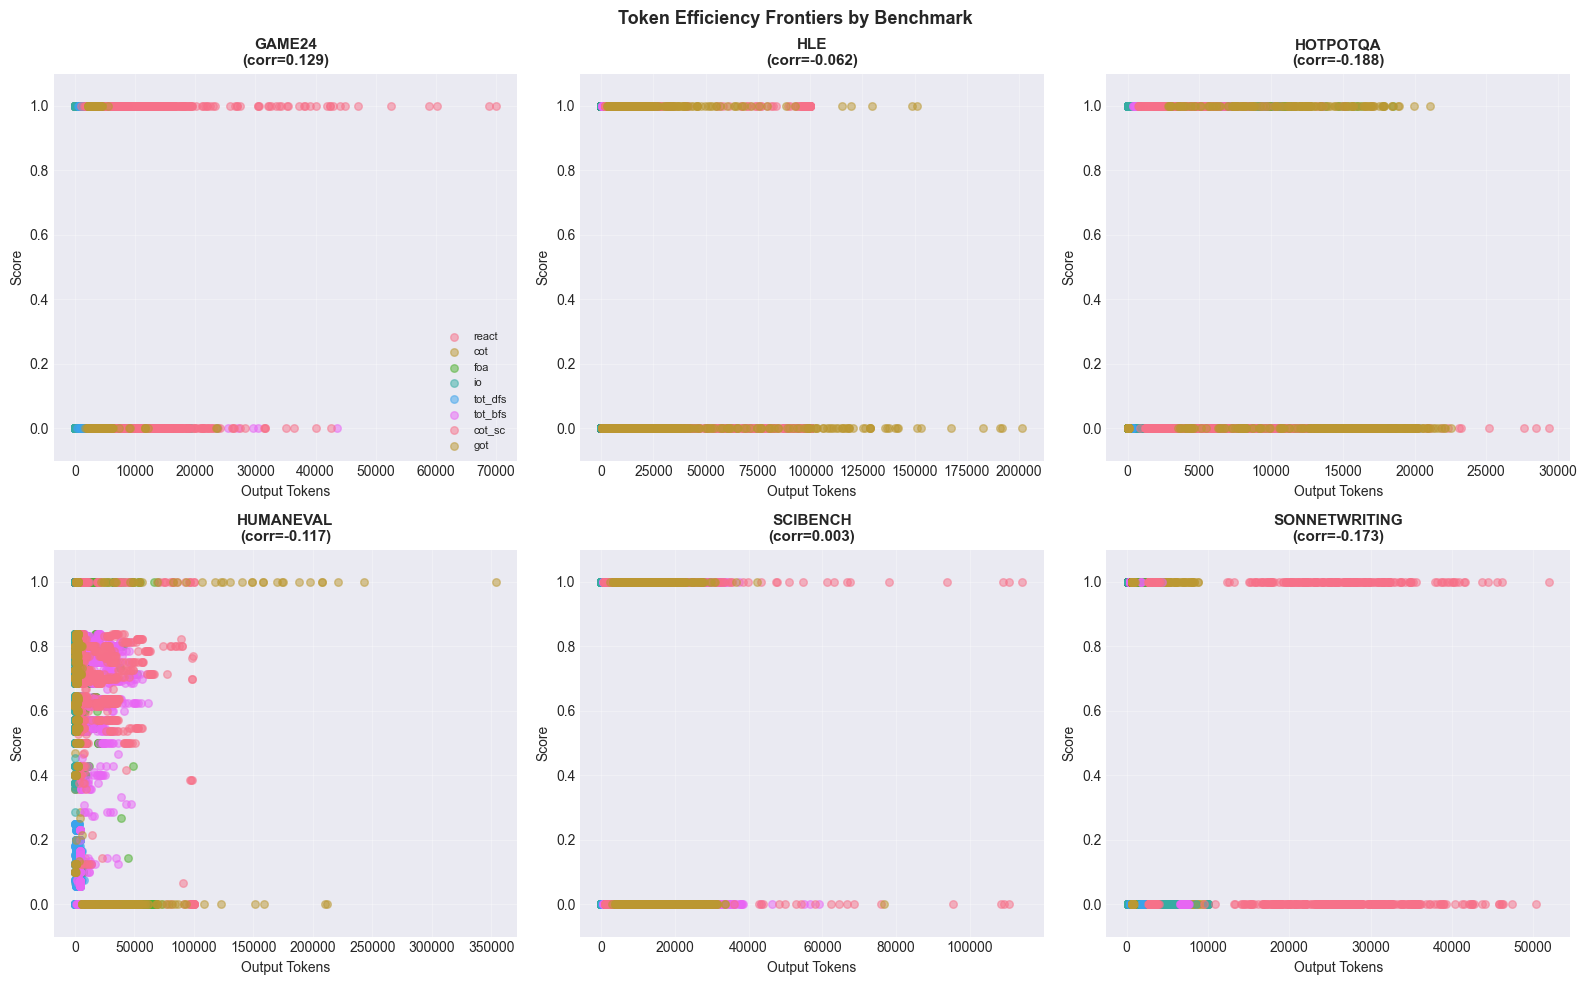


Token Efficiency Analysis by Benchmark:
----------------------------------------------------------------------------------------------------

GAME24:
  Token-Score Correlation: 0.129
    → Token budget is IRRELEVANT
  Most Efficient Method: io (efficiency: 0.0625)
  Avg Tokens: 3874 ± 4965

HLE:
  Token-Score Correlation: -0.062
    → Token budget is IRRELEVANT
  Most Efficient Method: io (efficiency: 0.5000)
  Avg Tokens: 8598 ± 18440

HOTPOTQA:
  Token-Score Correlation: -0.188
    → Token budget is IRRELEVANT
  Most Efficient Method: io (efficiency: 0.2000)
  Avg Tokens: 4636 ± 5419

HUMANEVAL:
  Token-Score Correlation: -0.117
    → Token budget is IRRELEVANT
  Most Efficient Method: io (efficiency: 0.0435)
  Avg Tokens: 10068 ± 16783

SCIBENCH:
  Token-Score Correlation: 0.003
    → Token budget is IRRELEVANT
  Most Efficient Method: io (efficiency: 0.0667)
  Avg Tokens: 5103 ± 8330

SONNETWRITING:
  Token-Score Correlation: -0.173
    → Token budget is IRRELEVANT
  Most Efficien

/var/folders/k_/c3cbvfzs61374h16mfb1dxb00000gn/T/ipykernel_10828/2272935406.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bench_data['efficiency'] = bench_data['score'] / (bench_data['tokens_out'] + 1)
/var/folders/k_/c3cbvfzs61374h16mfb1dxb00000gn/T/ipykernel_10828/2272935406.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bench_data['efficiency'] = bench_data['score'] / (bench_data['tokens_out'] + 1)
/var/folders/k_/c3cbvfzs61374h16mfb1dxb00000gn/T/ipykernel_10828/2272935406.py:65: SettingWith

In [8]:
print("\n" + "="*100)
print("ANALYSIS 3: TOKEN EFFICIENCY FRONTIERS BY PROBLEM TYPE")
print("="*100)

# Prepare data for efficiency analysis
efficiency_data = []
for idx, row in df_all.iterrows():
    scores = row['scores']
    tokens_out = row['tokens_out']
    tokens_in = row['tokens_in']
    
    for trial_idx in range(len(scores)):
        score = scores[trial_idx]
        tokens = tokens_out[trial_idx]
        
        efficiency_data.append({
            'Benchmark': row['Benchmark'],
            'Method': row['Method'],
            'score': score,
            'tokens_out': tokens,
            'tokens_in': tokens_in[trial_idx]
        })

eff_df = pd.DataFrame(efficiency_data)

# Visualize efficiency frontiers
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

benchmarks = sorted(eff_df['Benchmark'].unique())

for bench_idx, benchmark in enumerate(benchmarks):
    ax = axes[bench_idx]
    bench_data = eff_df[eff_df['Benchmark'] == benchmark]
    
    # Scatter plot: tokens vs score, colored by method
    for method in bench_data['Method'].unique():
        method_data = bench_data[bench_data['Method'] == method]
        ax.scatter(method_data['tokens_out'], method_data['score'], 
                  label=method, alpha=0.5, s=30)
    
    # Calculate correlations
    corr = bench_data['tokens_out'].corr(bench_data['score'])
    
    ax.set_xlabel('Output Tokens', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(f'{benchmark.upper()}\n(corr={corr:.3f})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)
    if bench_idx == 0:
        ax.legend(fontsize=8, loc='best')

plt.suptitle('Token Efficiency Frontiers by Benchmark', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Analysis by benchmark
print("\nToken Efficiency Analysis by Benchmark:")
print("-" * 100)
for benchmark in benchmarks:
    bench_data = eff_df[eff_df['Benchmark'] == benchmark]
    corr = bench_data['tokens_out'].corr(bench_data['score'])
    
    # Find efficient methods (high score per token)
    bench_data['efficiency'] = bench_data['score'] / (bench_data['tokens_out'] + 1)
    best_efficient = bench_data.loc[bench_data['efficiency'].idxmax()]
    
    print(f"\n{benchmark.upper()}:")
    print(f"  Token-Score Correlation: {corr:.3f}")
    if corr > 0.3:
        print(f"    → MORE tokens HELP (+)")
    elif corr < -0.3:
        print(f"    → MORE tokens HURT (-)")
    else:
        print(f"    → Token budget is IRRELEVANT")
    
    print(f"  Most Efficient Method: {best_efficient['Method']} (efficiency: {best_efficient['efficiency']:.4f})")
    print(f"  Avg Tokens: {bench_data['tokens_out'].mean():.0f} ± {bench_data['tokens_out'].std():.0f}")

## Analysis 4: Per-Agent Reasoning Diversity in Multi-Agent Methods

**Hypothesis:** In multi-agent methods, agent disagreement (diversity) correlates with outcome variance. High diversity might increase exploration but also increase variance.

In [9]:
def parse_agent_statistics_from_log(log_path):
    """
    Extract per-agent statistics from logs.
    Look for patterns like "Tab-idx###: ... Cost: ... Tokens: ..."
    """
    try:
        with open(log_path, 'r') as f:
            content = f.read()
        
        # Find all tab sections
        tab_pattern = r'Tab-idx(\d+):([\s\S]*?)(?=Tab-idx|$)'
        tabs = re.findall(tab_pattern, content)
        
        agent_costs = []
        agent_tokens = []
        
        for tab_id, tab_content in tabs:
            # Extract cost
            cost_match = re.search(r"'total': ([\d.]+)", tab_content)
            if cost_match:
                agent_costs.append(float(cost_match.group(1)))
            
            # Extract tokens
            token_match = re.search(r"'out': ([\d.]+)", tab_content)
            if token_match:
                agent_tokens.append(float(token_match.group(1)))
        
        if len(agent_costs) > 1:  # Only multi-agent methods
            return {
                'num_agents': len(agent_costs),
                'agent_costs': agent_costs,
                'agent_tokens': agent_tokens,
                'cost_diversity': (max(agent_costs) - min(agent_costs)) / (np.mean(agent_costs) + 1e-6),
                'token_diversity': (max(agent_tokens) - min(agent_tokens)) / (np.mean(agent_tokens) + 1e-6)
            }
    except:
        pass
    return None

print("\n" + "="*100)
print("ANALYSIS 4: MULTI-AGENT REASONING DIVERSITY")
print("="*100)

# Multi-agent methods to analyze
multi_agent_methods = ['foa', 'tot_dfs', 'tot_bfs']

agent_diversity_data = []
for idx, row in df_all.iterrows():
    if row['Method'] not in multi_agent_methods:
        continue
    
    log_path = row['log']
    if pd.isna(log_path):
        continue
    
    agent_stats = parse_agent_statistics_from_log(log_path)
    if agent_stats is None:
        continue
    
    scores = row['scores']
    
    agent_diversity_data.append({
        'method': row['Method'],
        'benchmark': row['Benchmark'],
        'num_agents': agent_stats['num_agents'],
        'cost_diversity': agent_stats['cost_diversity'],
        'token_diversity': agent_stats['token_diversity'],
        'mean_score': np.mean(scores),
        'score_variance': np.var(scores),
        'score_cv': np.std(scores) / (np.mean(scores) + 1e-6)
    })

agent_df = pd.DataFrame(agent_diversity_data)

if len(agent_df) > 0:
    print("\nMulti-Agent Diversity Analysis:")
    print(agent_df.to_string(index=False))
    
    # Correlations
    print("\n" + "-"*100)
    print("CORRELATION ANALYSIS:")
    print("-"*100)
    
    if 'cost_diversity' in agent_df.columns and 'score_variance' in agent_df.columns:
        corr_cost_var = agent_df['cost_diversity'].corr(agent_df['score_variance'])
        print(f"\nCost Diversity vs Score Variance: {corr_cost_var:.3f}")
        if corr_cost_var > 0.3:
            print("  → HIGH agent diversity INCREASES outcome variance")
        elif corr_cost_var < -0.3:
            print("  → HIGH agent diversity REDUCES outcome variance (alignment)")
        else:
            print("  → Agent diversity has MINIMAL impact on outcome variance")
    
    if 'cost_diversity' in agent_df.columns and 'mean_score' in agent_df.columns:
        corr_cost_score = agent_df['cost_diversity'].corr(agent_df['mean_score'])
        print(f"\nCost Diversity vs Mean Score: {corr_cost_score:.3f}")
        if abs(corr_cost_score) > 0.3:
            print(f"  → Agent diversity impacts performance")
    
    # Method comparison
    print("\n" + "-"*100)
    print("MULTI-AGENT METHOD COMPARISON:")
    print("-"*100)
    method_stats = agent_df.groupby('method').agg({
        'cost_diversity': 'mean',
        'mean_score': 'mean',
        'score_variance': 'mean'
    })
    print(method_stats)
else:
    print("\nNo multi-agent method data found in logs. Ensure logs contain per-agent statistics.")


ANALYSIS 4: MULTI-AGENT REASONING DIVERSITY

Multi-Agent Diversity Analysis:
 method     benchmark  num_agents  cost_diversity  token_diversity  mean_score  score_variance  score_cv
    foa        game24          50        0.999093         1.383001    0.580000        0.243600  0.850961
    foa        game24          50        0.933602         1.258906    0.600000        0.240000  0.816495
    foa        game24          50        0.947133         1.509144    0.500000        0.250000  0.999998
    foa        game24          50        0.638133         0.792219    0.580000        0.243600  0.850961
    foa        game24          50        0.840424         1.205798    0.560000        0.246400  0.886404
tot_dfs        game24          50        1.880546         1.975141    0.640000        0.230400  0.749999
tot_bfs        game24          50        0.243247         0.441534    0.520000        0.249600  0.960767
tot_dfs        game24          50        1.965015         2.004539    0.720000    

## Summary: Root Causes of High LLM Reasoning Variance

Based on the 4 analyses, the key variance drivers are:

1. **Latency Patterns** - Do response latencies predict correctness?
2. **Cache Effects** - Caching trades variance for reduced exploration
3. **Token Inefficiency** - Different tasks need different token budgets; misalignment causes failures
4. **Agent Disagreement** - Multi-agent methods have higher variance due to diverse reasoning paths

**Implications for Reducing Variance:**
- Enable caching for consistency, disable for maximum performance
- Match token budgets to problem type (use negative correlations to guide)
- Reduce agent diversity in multi-agent methods for consistency
- Monitor latency patterns as early warning signals